In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader

In [ ]:
config = {
    "batch_size": 8,
    "num_epochs": 20,
    "lr": 10**-4,
    "seq_len": 200,
    "d_model": 512,
    "datasource": "Helsinki-NLP/opus-100",
    "lang_src": "en",
    "lang_tgt": "zh",
    "model_folder": "weights",
    "model_basename": "tmodel_",
    "preload": "latest",
    "tokenizer_file": "tokenizer_{0}.json",
    "experiment_name": "runs/tmodel",
}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
print("Using device:", device)
if (device == 'cuda'):
    print(f"Device name: {torch.cuda.get_device_name(device.index)}")
    print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
elif (device == 'mps'):
    print(f"Device name: <mps>")
else:
    print("NOTE: If you have a GPU, consider using it for training.")
device = torch.device(device)

Using device: cpu
NOTE: If you have a GPU, consider using it for training.


<ipython-input-4-1e54a1671500>:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"


In [ ]:
# 加载原始数据集
train_dataset = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='train')
val_dataset = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='validation')
test_dataset = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='test')

print("训练集结构:", train_dataset)
print("\n验证集结构:", val_dataset)
print("\n测试集结构:", test_dataset)

# 查看特征结构
print("\n特征说明:", train_dataset.features)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


训练集结构: Dataset({
    features: ['translation'],
    num_rows: 1000000
})

验证集结构: Dataset({
    features: ['translation'],
    num_rows: 2000
})

测试集结构: Dataset({
    features: ['translation'],
    num_rows: 2000
})

特征说明: {'translation': Translation(languages=['en', 'zh'], id=None)}


In [ ]:
for item in train_dataset.select(range(5)):
    print(item["translation"])

{'en': 'Sixty-first session', 'zh': '第六十一届会议'}
{'en': 'I took some medicine for my mu for my mu my muscular for my muscular...', 'zh': '减轻酸... 酸痛的药 减轻酸痛的药'}
{'en': "It's a challenge. God is challenging you. He's calling you a chump.", 'zh': '上帝在挑战你，他说你是笨蛋'}
{'en': 'Oh, baby.', 'zh': '.. 寶貝'}
{'en': '- Lucinda?', 'zh': '- 盧辛達？'}


In [ ]:
from pathlib import Path
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

def get_or_build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))
    if not Path.exists(tokenizer_path):
        print(f"Building tokenizer for {lang}")
        tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        trainer = BpeTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)

        tokenizer.pre_tokenizer = Whitespace()

        tokenizer.train_from_iterator(ds, trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        print(f"Loading tokenizer for {lang}")
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer

In [ ]:
# 提取特定语言的文本数据
def extract_text(ds, lang):
    return [item['translation'][lang] for item in ds]

# 提取训练数据的源语言和目标语言文本
train_src_texts = extract_text(train_dataset, config['lang_src'])
train_tgt_texts = extract_text(train_dataset, config['lang_tgt'])
j
# 训练源语言和目标语言的分词器
src_tokenizer = get_or_build_tokenizer(config, train_src_texts, config['lang_src'])
tgt_tokenizer = get_or_build_tokenizer(config, train_tgt_texts, config['lang_tgt'])

Loading tokenizer for en
Loading tokenizer for zh


In [ ]:
def show_tokenization_samples(dataset, en_tokenizer, zh_tokenizer, num_samples=3):
    """展示英中文本的分词效果"""
    # 随机选择样本以获得更好的代表性
    samples = dataset.shuffle().select(range(num_samples))

    for i, item in enumerate(samples, 1):
        translation = item['translation']
        en_text = translation['en']
        zh_text = translation['zh']

        # 对英文进行分词
        en_tokens = en_tokenizer.encode(en_text).tokens
        # 对中文进行分词
        zh_tokens = zh_tokenizer.encode(zh_text).tokens

        print(f"\n样本 {i}:")
        print(f"英文原文: {en_text}")
        print(f"英文分词: {en_tokens}")
        print(f"中文原文: {zh_text}")
        print(f"中文分词: {zh_tokens}")
        print(f"英文词数: {len(en_tokens)}, 中文字数: {len(zh_tokens)}")
        print("-" * 50)

# 使用示例
print("分词效果展示：")
show_tokenization_samples(train_dataset, src_tokenizer, tgt_tokenizer)

分词效果展示：

样本 1:
英文原文: 3.2 The authors also allege discrimination under article 26 of the Covenant.
英文分词: ['3', '.', '2', 'The', 'authors', 'also', 'alle', 'ge', 'discrimination', 'under', 'article', '26', 'of', 'the', 'Covenant', '.']
中文原文: 3.2 申诉人还指称存在《公约》第二十六条所指的歧视现象。
中文分词: ['3', '.', '2', '申诉人', '还', '指称', '存在', '《', '公约', '》', '第二十六条', '所指', '的歧视', '现象', '。']
英文词数: 16, 中文字数: 15
--------------------------------------------------

样本 2:
英文原文: All implementation lies at district and provincial level.
英文分词: ['All', 'implementation', 'lies', 'at', 'district', 'and', 'provincial', 'level', '.']
中文原文: 所有实施工作均在县和省两级进行。
中文分词: ['所有', '实施', '工作', '均', '在', '县', '和', '省', '两级', '进行', '。']
英文词数: 9, 中文字数: 11
--------------------------------------------------

样本 3:
英文原文: The executive board shall have the authority to review and audit decisions of the designated operational entities and, to the degree they find that project activities would have been carried out anyway in the absence of the CDM, 

In [ ]:
import os
from tqdm import tqdm
import torch

def encode_text(tokenizer, text):
    # 使用分词器对文本进行编码
    encoding = tokenizer.encode(text).ids
    return torch.tensor(encoding, dtype=torch.int64)

def encode_dataset(config, dataset, src_tokenizer, tgt_tokenizer):

    src_texts = [item['translation'][config['lang_src']] for item in dataset]
    tgt_texts = [item['translation'][config['lang_tgt']] for item in dataset]

    # 编码源语言和目标语言文本
    src_encoded = [encode_text(src_tokenizer, text) for text in tqdm(src_texts, desc="Encoding source texts")]
    tgt_encoded = [encode_text(tgt_tokenizer, text) for text in tqdm(tgt_texts, desc="Encoding target texts")]

    return src_encoded, tgt_encoded

def get_data(config, type, dataset, src_tokenizer, tgt_tokenizer):
    data_src, data_tgt = encode_dataset(config, dataset, src_tokenizer, tgt_tokenizer)
    return data_src, data_tgt

train_data_src, train_data_tgt = get_data(config, "train", train_dataset, src_tokenizer, tgt_tokenizer)

Encoding target texts: 100%|██████████| 1000000/1000000 [01:25<00:00, 11758.61it/s]


In [ ]:
# 获取 train_data_src 中所有序列的长度
seq_lengths = [tensor.size(0) for tensor in train_data_tgt]

# 找到最长的序列长度
max_seq_len = max(seq_lengths)

print(f"The longest sequence length in train_data_src is: {max_seq_len}")

The longest sequence length in train_data_src is: 122055


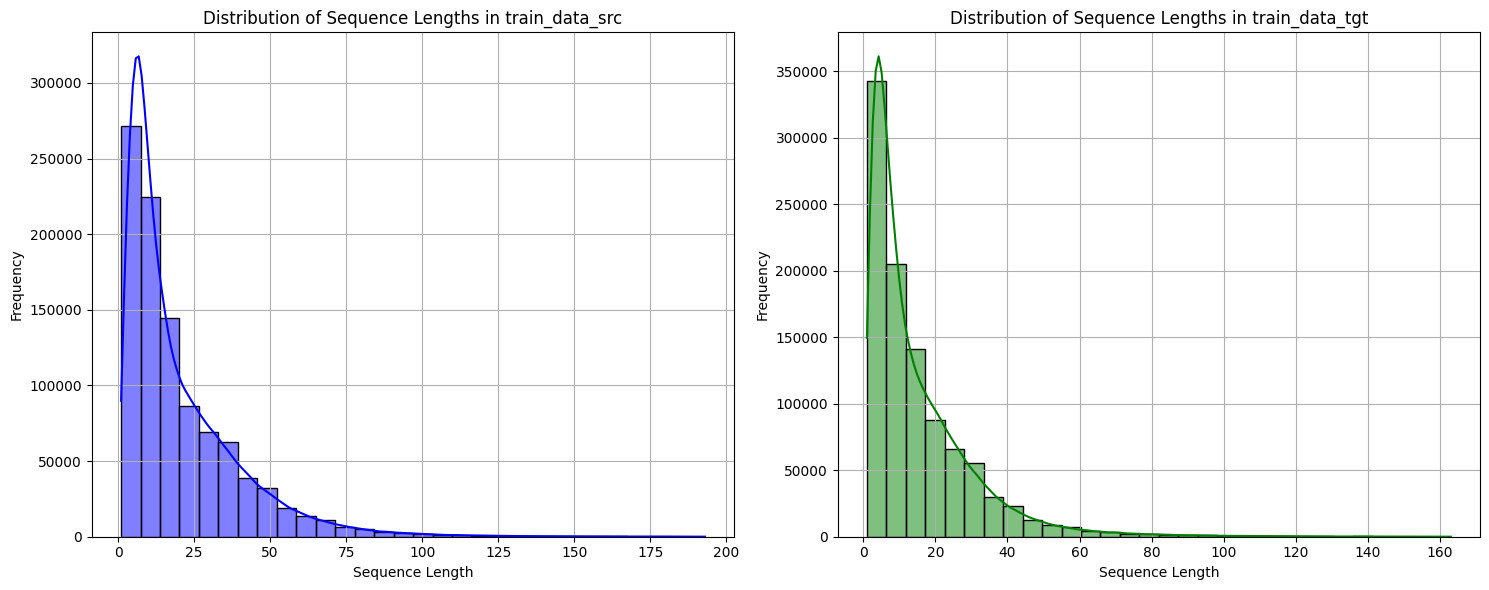

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 获取 train_data_src 和 train_data_tgt 中所有序列的长度
seq_lengths_src = [tensor.size(0) for tensor in train_data_src]
seq_lengths_tgt = [tensor.size(0) for tensor in train_data_tgt]

# 创建一个包含两个子图的图形
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 绘制 train_data_src 的直方图
sns.histplot(sorted(seq_lengths_src)[:-1000], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Sequence Lengths in train_data_src')
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# 绘制 train_data_tgt 的直方图
sns.histplot(sorted(seq_lengths_tgt)[:-1000], bins=30, kde=True, color='green', ax=axes[1])
axes[1].set_title('Distribution of Sequence Lengths in train_data_tgt')
axes[1].set_xlabel('Sequence Length')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# 显示图形
plt.tight_layout()
plt.show()

可以看出大部分的序列长度在200以内, 选取seq_len = 200

包装到类BilingualDataset

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

class BilingualDataset(Dataset):

    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()
        self.seq_len = seq_len

        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        src_target_pair = self.ds[idx]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Transform the text into tokens
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids
        if len(enc_input_tokens) > self.seq_len - 2:
            enc_input_tokens = enc_input_tokens[:self.seq_len - 2]
            enc_input_tokens[-1] = self.eos_token
        if len(dec_input_tokens) > self.seq_len - 1:
            dec_input_tokens = dec_input_tokens[:self.seq_len - 1]
            dec_input_tokens[-1] = self.eos_token

        # Add sos, eos and padding to each sentence
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2  # We will add <s> and </s>
        # We will only add <s>, and </s> only on the label
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        # Make sure the number of padding tokens is not negative. If it is, the sentence is too long
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")

        # Add <s> and </s> token
        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only <s> token
        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only </s> token
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Double check the size of the tensors to make sure they are all seq_len long
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,  # (seq_len)
            "decoder_input": decoder_input,  # (seq_len)
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).int(), # (1,  seq_len)
            "decoder_mask": (decoder_input != self.pad_token).int() & causal_mask(decoder_input.size(0)), # (seq_len) & (seq_len, seq_len),
            "label": label,  # (seq_len)
            "src_text": src_text,
            "tgt_text": tgt_text,
        }

def causal_mask(size):
    mask = torch.triu(torch.ones((size, size)), diagonal=1).type(torch.int)
    return mask == 0

In [ ]:
train_ds = BilingualDataset(train_dataset, src_tokenizer, tgt_tokenizer, config['lang_src'], config['lang_tgt'], config['seq_len'])
val_ds = BilingualDataset(val_dataset, src_tokenizer, tgt_tokenizer, config['lang_src'], config['lang_tgt'], config['seq_len'])

In [ ]:
train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
print(batch.keys())
encoder_input = batch['encoder_input'] # (b, seq_len)
decoder_input = batch['decoder_input'] # (B, seq_len)
encoder_mask = batch['encoder_mask'] # (B, 1, seq_len)
decoder_mask = batch['decoder_mask'] # (B, seq_len, seq_len)
label = batch['label'] # (B, seq_len)
src_text = batch['src_text']
tgt_text = batch['tgt_text']
print(f'{encoder_input.shape=}')
print(f'{decoder_input.shape=}')
print(f'{encoder_mask.shape=}')
print(f'{decoder_mask.shape=}')
print(f'{label.shape=}')
print(src_text[0])
print(tgt_text[0])

dict_keys(['encoder_input', 'decoder_input', 'encoder_mask', 'decoder_mask', 'label', 'src_text', 'tgt_text'])
encoder_input.shape=torch.Size([8, 200])
decoder_input.shape=torch.Size([8, 200])
encoder_mask.shape=torch.Size([8, 1, 200])
decoder_mask.shape=torch.Size([8, 200, 200])
label.shape=torch.Size([8, 200])
Emphasizing the importance for States of protecting and preserving their cultural heritage in accordance with relevant international instruments such as the Convention on the Means of Prohibiting and Preventing the Illicit Import, Export and Transfer of Ownership of Cultural Property, adopted by the United Nations Educational, Scientific and Cultural Organization on 14 November 1970, the Convention on Stolen or Illegally Exported Cultural Objects, adopted at Rome on 24 June 1995 by the International Institute for the Unification of Private Law, and the Convention for the Protection of Cultural Property in the Event of Armed Conflict, adopted at The Hague on 14 May 1954, and the

## 构造模型

In [ ]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F

class Inputembddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.d_model = d_model
        self.vocab = vocab
        self.embedding = nn.Embedding(vocab, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, seq_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model) # (seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)

        pe[:, 0::2]  = torch.sin(position * div_term) # (seq_len, d_model / 2)
        pe[:, 1::2]  = torch.cos(position * div_term) # (seq_len, d_model / 2)

        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

class LayerNormalization(nn.Module):

    def __init__(self, d_model: int, eps=10**-6):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(d_model))
        self.bias = nn.Parameter(torch.zeros(d_model))

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

class FeedForwardBlock(nn.Module):

    def __init__(self, d_model, dropout=0.1) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_model*4)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_model*4, d_model)

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

class Head(nn.Module):
    """one head of self-attention"""

    def __init__(self, d_model, head_size, dropout=0.1):
        super().__init__()
        self.key = nn.Linear(d_model, head_size, bias=False)
        self.query = nn.Linear(d_model, head_size, bias=False)
        self.value = nn.Linear(d_model, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head_size)
        B, T, C = q.shape
        q = self.query(q)  # (B,T,hs)
        k = self.key(k)  # (B,T,hs)
        # compute attention scores ("affinities")
        wei = (
            q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        )  # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        if mask is not None:
            wei = wei.masked_fill(mask == 0, float("-inf"))  # (B, T, T)

        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(v)  # (B,T,hs)
        out = wei @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallel"""

    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        head_size = d_model // num_heads
        self.heads = nn.ModuleList([Head(d_model, head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask):
        out = torch.cat([h(q, k, v, mask) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class ResidualConnection(nn.Module):

        def __init__(self, d_model, dropout=0.1) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(d_model)

        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

class EncoderBlock(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.self_attention_block = MultiHeadAttention(d_model, num_heads)
        self.feed_forward_block = FeedForwardBlock(d_model)
        self.residual_connection1 = ResidualConnection(d_model)
        self.residual_connection2 = ResidualConnection(d_model)

    def forward(self, x, src_mask):
        x = self.residual_connection1(x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connection2(x, self.feed_forward_block)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.self_attention_block = MultiHeadAttention(d_model, num_heads)
        self.cross_attention_block = MultiHeadAttention(d_model, num_heads)
        self.feed_forward_block = FeedForwardBlock(d_model)
        self.residual_connections = [ResidualConnection(d_model) for _ in range(3)]

    def forward(self, x, encoder_out, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_out, encoder_out, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, seq_len, d_model, N=6, num_heads=8):
        super().__init__()
        self.src_embed = Inputembddings(d_model, src_vocab_size)
        self.tgt_embed = Inputembddings(d_model, tgt_vocab_size)
        # src and tgt use a single positional encode
        self.positional_encoding = PositionalEncoding(d_model, seq_len)

        # Create the encoder blocks
        self.encoder_blocks = []
        for _ in range(N):
            encoder_block = EncoderBlock(d_model, num_heads)
            self.encoder_blocks.append(encoder_block)

        # Create the decoder blocks
        self.decoder_blocks = []
        for _ in range(N):
            decoder_block = DecoderBlock(d_model, num_heads)
            self.decoder_blocks.append(decoder_block)

        # layer norm
        self.ec_norm = LayerNormalization(d_model)
        self.dc_norm = LayerNormalization(d_model)

        # pro layer
        self.projection_layer = nn.Linear(d_model, tgt_vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def encode(self, x, src_mask):
        x = self.src_embed(x)
        x = self.positional_encoding(x)
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x, src_mask)
        return self.ec_norm(x)

    def decode(self, x, encoder_out, src_mask, tgt_mask):
        x = self.tgt_embed(x)
        x = self.positional_encoding(x)
        for decoder_block in self.decoder_blocks:
            x = decoder_block(x, encoder_out, src_mask, tgt_mask)
        return self.dc_norm(x)

    def forward(self, src, tgt, src_mask, tgt_mask, target=None):
        encoder_out = self.encode(src, src_mask)
        decoder_out = self.decode(tgt, encoder_out, src_mask, tgt_mask)
        logits = self.projection_layer(decoder_out)
        if target is not None:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            target = target.view(B * T)
            loss = F.cross_entropy(logits, target, ignore_index=0)
        else:
            loss = None
        return logits, loss

    def generate(self, src, src_mask, max_len, tgt_tokenizer, device):
        memory = self.encode(src, src_mask)
        memory = memory.to(device)

        decoder_input = torch.ones(1, 1).fill_(1).type(torch.long).to(device)
        for i in tqdm(range(max_len - 1), position=0):
            decoder_mask = self.causal_mask(i + 1).type(torch.int)
            out = self.decode(decoder_input, memory, src_mask, decoder_mask)
            prob = self.projection_layer(out[:, -1])
            _, next_word = torch.max(prob, dim=1)
            decoder_input = torch.cat([decoder_input, torch.ones(1, 1).type_as(src.data).fill_(next_word.item())], dim=1)
            if next_word == tgt_tokenizer.token_to_id("[EOS]"):
                break
        return decoder_input.view(-1)

    def causal_mask(self, size):
        mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
        return mask == 0

In [ ]:
model = Transformer(src_tokenizer.get_vocab_size(), tgt_tokenizer.get_vocab_size(), config['seq_len'], config['d_model'])
m = model.to(device)

In [ ]:
print(sum(p.numel() for p in m.parameters()) / 1e6, "M parameters")

46.112048 M parameters


In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=config['lr'])

In [ ]:
from tqdm import tqdm

for epoch in range(config['num_epochs']):
    torch.cuda.empty_cache()
    model.train()
    batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
    for batch in batch_iterator:

        encoder_input = batch['encoder_input'].to(device) # (b, seq_len)
        decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
        encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len)
        decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)
        label = batch['label'].to(device) # (B, seq_len)

        # Compute the loss using a simple cross entropy
        logits, loss = model(encoder_input, decoder_input, encoder_mask, decoder_mask, label)
        batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

        # Backpropagate the loss
        loss.backward()

        # Update the weights
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        break
    break

Processing Epoch 00:   0%|          | 0/125000 [00:16<?, ?it/s, loss=10.645]


In [ ]:
@torch.no_grad()
def show_test(val_dataloader, model, tgt_tokenizer, early_stop=5):
    model.eval()
    count = 0
    source_texts = []
    expected = []
    predicted = []

    batch_iterator = tqdm(val_dataloader, desc=f"Processing eval")

    for batch in batch_iterator:
        if count > early_stop:
            break
        count += 1
        encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
        encoder_mask = batch["encoder_mask"].to(device) # (b, 1, seq_len)

        # check that the batch size is 1
        assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"

        model_out = model.generate(encoder_input, encoder_mask, config['seq_len'], tgt_tokenizer, device)

        source_text = batch["src_text"][0]
        target_text = batch["tgt_text"][0]
        model_out_text = tgt_tokenizer.decode(model_out.detach().cpu().numpy())

        source_texts.append(source_text)
        expected.append(target_text)
        predicted.append(model_out_text)

    return source_texts, expected, predicted

source_texts, expected, predicted = show_test(val_dataloader, model, tgt_tokenizer)
print(source_texts[0])
print(expected[0])
print(predicted[0])

Processing eval:   0%|          | 6/2000 [00:08<49:00,  1.47s/it]

(b) When not less than 20 High Contracting Parties have agreed to accept the competence of the Commission pursuant to paragraph 2, the depositary shall then, and at intervals of five years thereafter, convene a meeting of representatives of those High Contracting Parties for the purpose of electing the members of the Commission.
(二) 当缔约各方二十个以上已经按照第二款同意接受调委会的职权时，保存者应于该时及其后每隔五年召开缔约各该方代表会议，以选举调委会委员。
只需 监督和 子女的 程度 也应 社区 Sm uary 章节 丫 令人关切 同时也


In [ ]:
@torch.no_grad()
def estimate_loss(model, val_dataloader):
    model.eval()
    losses = []
    batch_iterator = tqdm(val_dataloader, desc=f"Processing eval")
    for batch in batch_iterator:
        encoder_input = batch['encoder_input'].to(device) # (b, seq_len)
        decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
        encoder_mask = batch['encoder_mask'].to(device) # (B, 1,
        decoder_mask = batch['decoder_mask'].to(device) # (B,
        label = batch['label'].to(device) # (B, seq_len)

        # Compute the loss using a simple cross entropy
        logits, loss = model(encoder_input, decoder_input, encoder_mask, decoder_mask, label)
        losses.append(loss.item())
    return sum(losses) / len(losses)

print(estimate_loss(model, val_dataloader))

Processing eval:   0%|          | 0/2000 [00:00<?, ?it/s]

10.367456436157227
